In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

In [ ]:
df=pd.read_csv("/content/KwhConsumptionBlower78_1.csv")
print(df.shape)
df.head()

(1228, 4)


,Unnamed: 0,TxnDate,TxnTime,Consumption
0,76229,01 Jan 2022,16:55:52,1.010
1,76258,01 Jan 2022,21:45:29,0.908
2,76287,01 Jan 2022,12:24:52,0.926
3,76316,01 Jan 2022,04:07:36,0.928
4,76345,01 Jan 2022,06:52:25,0.916


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1228 non-null   int64  
 1   TxnDate      1228 non-null   object 
 2   TxnTime      1228 non-null   object 
 3   Consumption  1228 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 38.5+ KB


In [ ]:
df['Datetime']=pd.to_datetime(df['TxnDate'])

In [ ]:
df=df.groupby('Datetime').sum('Consumption').drop('Unnamed: 0',axis=1)
df.head(2)

,Consumption
Datetime,
2022-01-01,65.462
2022-01-02,268.450


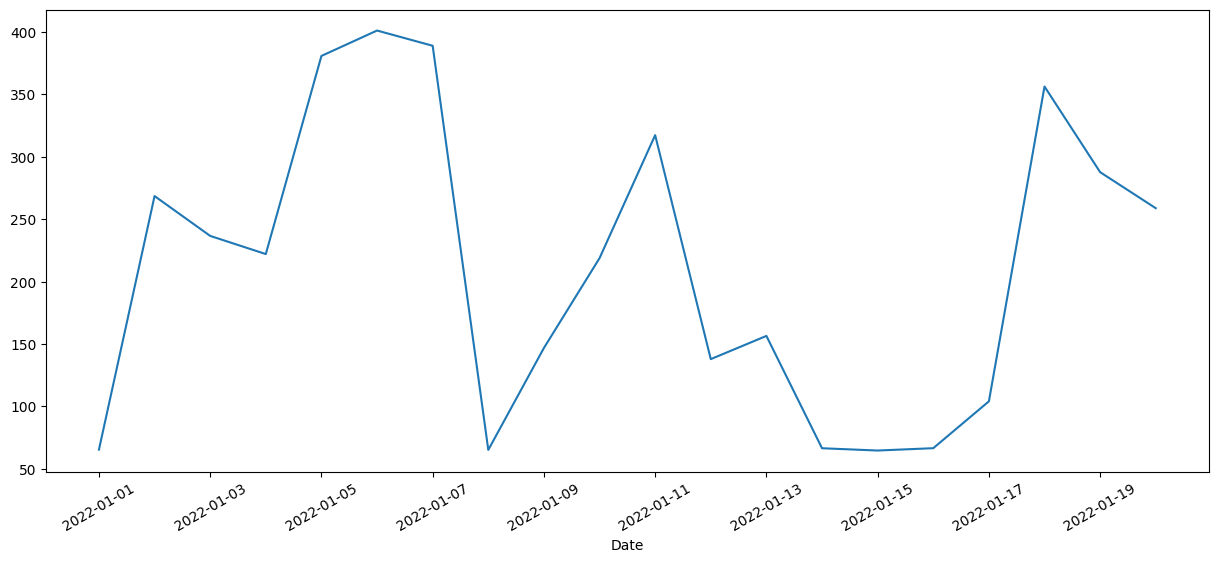

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df)
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

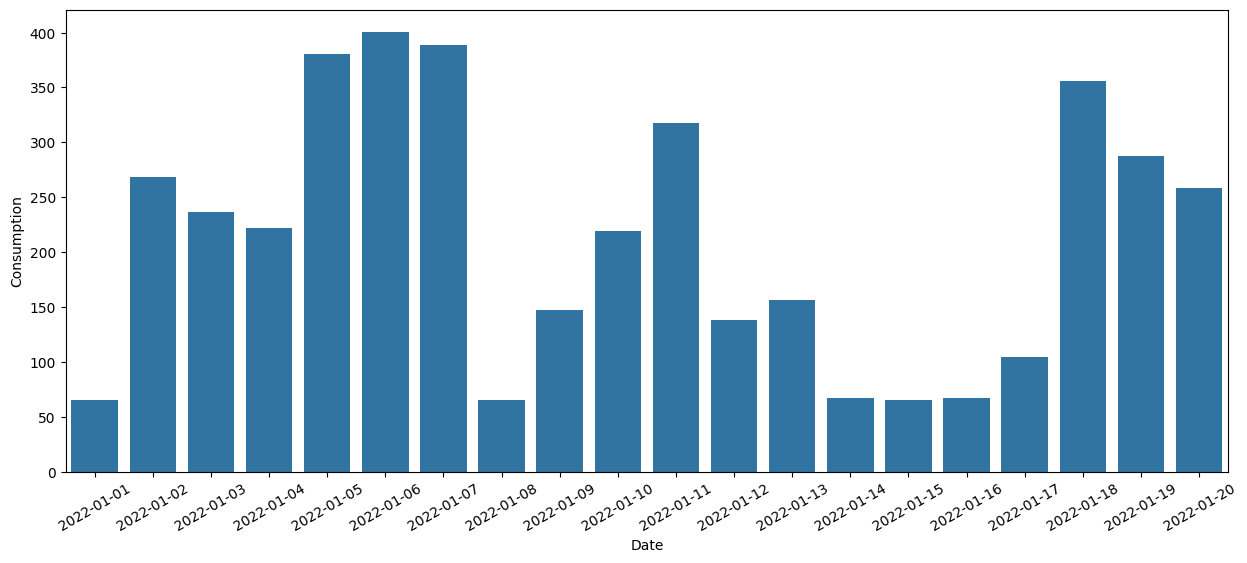

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x=df.index,y="Consumption")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

In [ ]:
rolling_mean_df=df.rolling(window=4).mean()

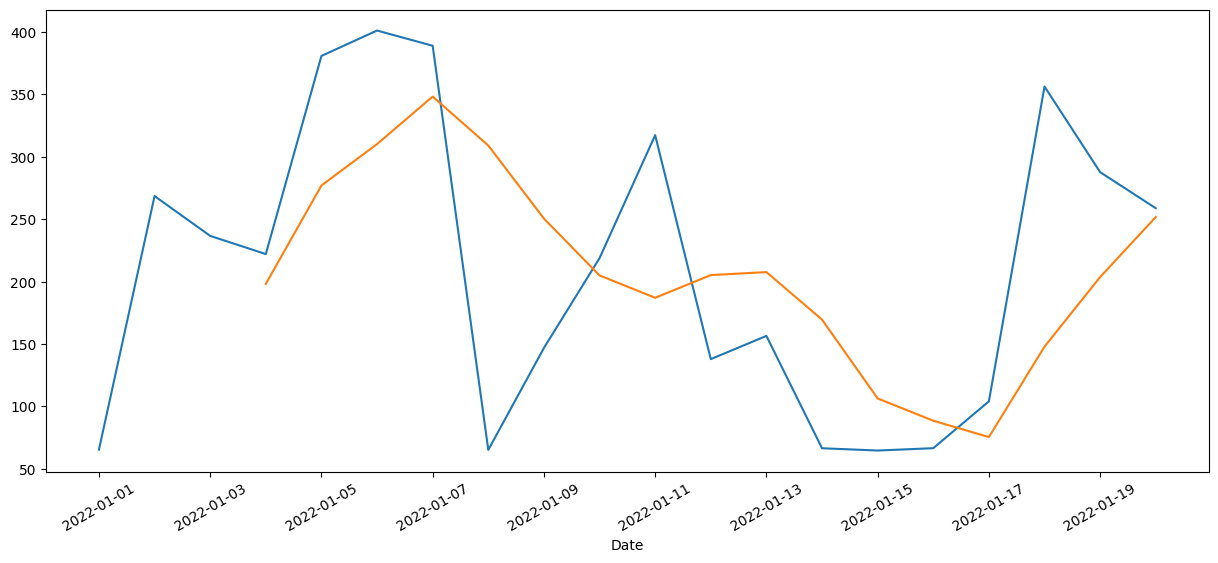

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df)
plt.plot(rolling_mean_df)
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

In [ ]:
df=df.asfreq('D')

In [ ]:
simp_smoothing=SimpleExpSmoothing(df)
simp_smoothing_d=simp_smoothing.fit(smoothing_level=0.2,optimized=False)
exp_smoothing=ExponentialSmoothing(df)
exp_smoothing_d=exp_smoothing.fit(smoothing_level=0.2,optimized=False)

In [ ]:
holt_normal=Holt(df).fit()
holt_exp=Holt(df,exponential=True).fit()

# Smoothing Techniques

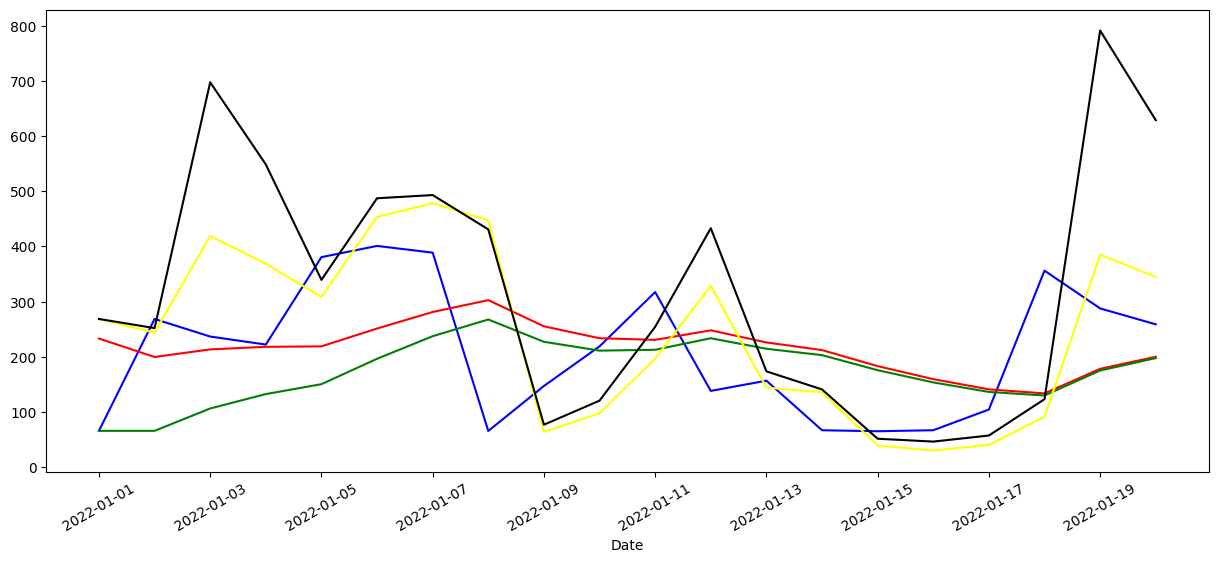

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(df,color='blue')
plt.plot(exp_smoothing_d.fittedvalues,color='red')
plt.plot(simp_smoothing_d.fittedvalues,color='green')
plt.plot(holt_normal.fittedvalues,color='yellow')
plt.plot(holt_exp.fittedvalues,color='black')
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.show()

# Decomposition of Data

In [ ]:
mul_result=seasonal_decompose(df,model='multiplicative',period=7)

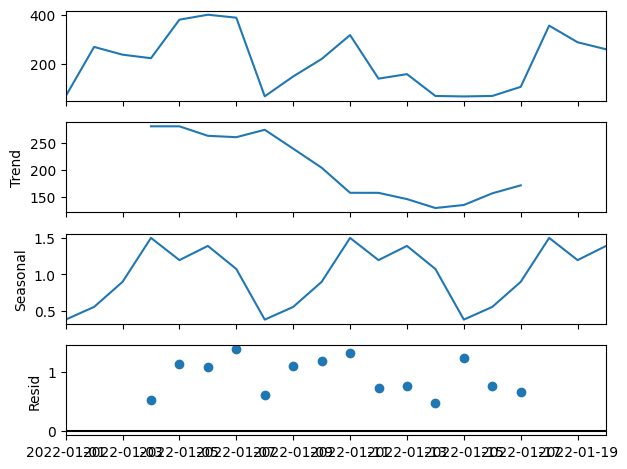

In [ ]:
mul_result.plot()
plt.show()

# Stationarity Check

In [ ]:
adfuller_check=adfuller(df['Consumption'],autolag='AIC')
print(f"p-vlue: {adfuller_check[1]}")

p-vlue: 0.053494810932901336


**Data is not stationary.**

In [ ]:
df_roll=df.rolling(window=4).mean().dropna()
adfuller_check=adfuller(df_roll,autolag='AIC')
print(f"p-vlue: {adfuller_check[1]}")

p-vlue: 0.09336380937670069


**Now the data is stationary. So can proceed with model building.**

In [ ]:
model = auto_arima(df['Consumption'], seasonal=True,m=7, stepwise=True, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.00 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=251.000, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=251.275, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=251.548, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=278.063, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=252.996, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=252.981, Time=0.14 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=254.980, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=249.498, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=251.308, Time=0.40 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=253.333, Time=0.38 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=250.982, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=251.246, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=249.643, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=250.869, 

In [ ]:
best_model = ARIMA(df, order=(3, 0, 0),seasonal_order=(1, 0, 0, 7))
best_model_fit = best_model.fit()

In [ ]:
best_model_fit.forecast(10)

,predicted_mean
2022-01-21,195.520058
2022-01-22,183.185130
2022-01-23,187.783317
2022-01-24,202.906007
2022-01-25,204.062626
2022-01-26,208.503016
2022-01-27,206.461246
2022-01-28,205.143916
2022-01-29,203.794992
2022-01-30,203.699028


In [ ]:
best_model_fit_gf=best_model_fit.get_forecast(steps=10)
forecast_mean = best_model_fit_gf.predicted_mean
forecast_conf_int = best_model_fit_gf.conf_int()
forecast_conf_int

,lower Consumption,upper Consumption
2022-01-21,-5.266936,396.307051
2022-01-22,-36.559521,402.929781
2022-01-23,-33.525454,409.092088
2022-01-24,-21.173449,426.985463
2022-01-25,-22.817255,430.942507
2022-01-26,-19.153850,436.159881
2022-01-27,-21.198604,434.121095
2022-01-28,-22.528249,432.816081
2022-01-29,-23.927697,431.517682
2022-01-30,-24.030290,431.428346


# **Final Output**

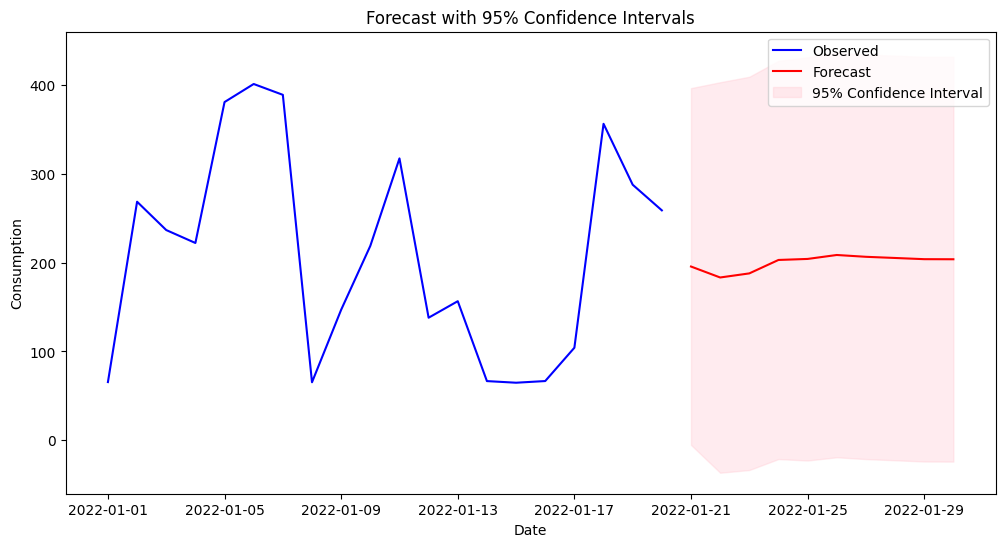

In [ ]:
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=10, freq='D')

forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower Confidence': forecast_conf_int.iloc[:, 0],
    'Upper Confidence': forecast_conf_int.iloc[:, 1]
}, index=forecast_index)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Consumption'], label='Observed', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], color='red', label='Forecast')
plt.fill_between(forecast_df.index, forecast_df['Lower Confidence'], forecast_df['Upper Confidence'],
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Forecast with 95% Confidence Intervals')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_actual = df['Consumption'][-10:]
y_pred = best_model_fit.forecast(steps=10)

mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
smape = 100 * np.mean(2 * np.abs(y_actual - y_pred) / (np.abs(y_actual) + np.abs(y_pred)))
r_squared = r2_score(y_actual, y_pred)

print("Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")
print(f"R-Squared: {r_squared:.2f}")


Evaluation Metrics:
MAE: 100.80
MSE: 11929.19
RMSE: 109.22
MAPE: nan%
SMAPE: nan%
R-Squared: -0.04


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual and predicted values
actual = df['Consumption']
predicted = best_model_fit.fittedvalues

# Metrics
mae = mean_absolute_error(actual, predicted)
rmse = mean_squared_error(actual, predicted, squared=False)  # RMSE is the square root of MSE
mape = (abs((actual - predicted) / actual).mean()) * 100  # Percentage error

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")


MAE: 88.77360849618235
RMSE: 103.74475063244108
MAPE: 70.12872174468083%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
